In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# tensorflow
import tensorflow as tf
from tensorflow import keras

from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, Conv1D, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

# Common imports
import os
import timeit
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from datetime import date
import holidays
sns.set()
import warnings
warnings.filterwarnings("ignore")

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.sans-serif"] = "Verdana"

In [2]:
df = pd.read_excel("data/Smart Freeways Data 2018 - Ramps All Days.xlsx",
                   skiprows=3, header=0)
df.head()

,Row Labels,01 Jan 18,02 Jan 18,03 Jan 18,04 Jan 18,05 Jan 18,06 Jan 18,07 Jan 18,08 Jan 18,09 Jan 18,...,23 Oct 18,24 Oct 18,25 Oct 18,26 Oct 18,27 Oct 18,28 Oct 18,29 Oct 18,30 Oct 18,31 Oct 18,01 Nov 18
0,KwN Manning On (130) (H547@310),3986.0,4988.0,5496.0,5685.0,5931.0,5324.0,4364.0,6188.0,6741.0,...,8808.0,8926.0,9306.0,9222.0,7147.0,5691.0,8532.0,8878.0,9133.0,9100.0
1,0130KWN-OR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0130KWN-OR1,3986.0,4988.0,5496.0,5685.0,5931.0,5324.0,4364.0,6188.0,6741.0,...,8808.0,8926.0,9306.0,9222.0,7147.0,5691.0,8532.0,8878.0,9133.0,9100.0
3,00:00 - 00:15,16.0,9.0,11.0,10.0,14.0,27.0,21.0,6.0,8.0,...,10.0,13.0,11.0,16.0,33.0,32.0,16.0,23.0,18.0,6.0
4,00:15 - 00:30,38.0,7.0,11.0,11.0,8.0,18.0,19.0,8.0,5.0,...,6.0,10.0,13.0,13.0,18.0,39.0,10.0,13.0,12.0,16.0


In [3]:
df = df[['Row Labels', '27 Aug 18']]
df['Time'] = df['Row Labels']
df = df[['Row Labels', 'Time', '27 Aug 18']]
df.head()

,Row Labels,Time,27 Aug 18
0,KwN Manning On (130) (H547@310),KwN Manning On (130) (H547@310),7493.0
1,0130KWN-OR,0130KWN-OR,NaN
2,0130KWN-OR1,0130KWN-OR1,7493.0
3,00:00 - 00:15,00:00 - 00:15,9.0
4,00:15 - 00:30,00:15 - 00:30,6.0


In [4]:
# For Row Labels, replace time format %H:%M - %H:%M with NaN
# For DateTime, replace everything else as NaN

df['Row Labels'] = df['Row Labels'].replace(
    '([01]?[0-9]|2[0-4]):[0-5][0-9](:[0-5][0-9])?\s-\s([01]?[0-9]|2[0-4]):[0-5][0-9](:[0-5][0-9])?',
    np.nan, regex=True)
df['Row Labels'] = df['Row Labels'].ffill(axis=0)
df['Row Labels'].unique()

array(['KwN Manning On (130) (H547@310)', '0130KWN-OR', '0130KWN-OR1',
       'KwN Mill Point Off (80) (H503@40)', '0080KWN-XR', '0080KWN-XR1',
       'KwN NoCanning On (84) (H549@240)', '0084KWN-ORL', '0084KWN-OR1L',
       '0084KWN-OR2L', '0084KWN-ORT', '0084KWN-OR1T', '0084KWN-OR2T',
       'KwN NoCranford On (150) (H553@140)', '0150KWN-OR', '0150KWN-OR1',
       'KwN NoFarrington On (200) (H622@280)', '0200KWN-ORL',
       '0200KWN-OR1L', '0200KWN-ORT', '0200KWN-OR1T',
       'KwN NoJudd On (81) (H500@470)', '0081KWN-ORL', '0081KWN-OR1L',
       '0081KWN-ORT', '0081KWN-OR1T',
       'KwN NoLeach East On (160) (H554@480)', '0160KWN-ORL',
       '0160KWN-OR1L', '0160KWN-ORT', '0160KWN-OR1T',
       'KwN NoRoe On (210) (H774@800)', '0210KWN-OR', '0210KWN-OR1',
       'KwN NoSouth St On (89) (H617@480)', '0089KWN-ORL', '0089KWN-OR1L',
       '0089KWN-OR2L', '0089KWN-ORT', '0089KWN-OR1T', '0089KWN-OR2T',
       'KwN SoCanning Off (130) (H551@360)', '0130KWN-XR1', '0130KWN-XR2',
       '

- if *Row Labels* contain '[K][w][N]\s', drop row

In [5]:
df = df[~df['Row Labels'].str.contains('KwN ', na=False)]
df = df[~df['Row Labels'].str.contains('Grand Total', na=False)]
df['Row Labels'].unique()

array(['0130KWN-OR', '0130KWN-OR1', '0080KWN-XR', '0080KWN-XR1',
       '0084KWN-ORL', '0084KWN-OR1L', '0084KWN-OR2L', '0084KWN-ORT',
       '0084KWN-OR1T', '0084KWN-OR2T', '0150KWN-OR', '0150KWN-OR1',
       '0200KWN-ORL', '0200KWN-OR1L', '0200KWN-ORT', '0200KWN-OR1T',
       '0081KWN-ORL', '0081KWN-OR1L', '0081KWN-ORT', '0081KWN-OR1T',
       '0160KWN-ORL', '0160KWN-OR1L', '0160KWN-ORT', '0160KWN-OR1T',
       '0210KWN-OR', '0210KWN-OR1', '0089KWN-ORL', '0089KWN-OR1L',
       '0089KWN-OR2L', '0089KWN-ORT', '0089KWN-OR1T', '0089KWN-OR2T',
       '0130KWN-XR1', '0130KWN-XR2', '0170KWN-XRL', '0170KWN-XR1L',
       '0170KWN-XRT', '0170KWN-XR1T', '0702KWN-ORL', '0702KWN-OR1L',
       '0702KWN-ORT', '0702KWN-OR1T', '0220KWN-XRL', '0220KWN-XR1L',
       '0220KWN-XR2L', '0220KWN-XRT', '0220KWN-XR1T', '0220KWN-XR2T',
       '0190KWN-XRL', '0190KWN-XR1L', '0190KWN-XRT', '0190KWN-XR1T'],
      dtype=object)

In [ ]:
df

In [6]:
OR_df = df.copy()

In [7]:
OR_df = OR_df[~OR_df['Row Labels'].str.contains('XR', na=False)]
OR_df = OR_df[~OR_df['Row Labels'].str.contains('210', na=False)]
OR_df = OR_df[OR_df['27 Aug 18'].notnull()]

OR_df.Time = OR_df.Time.str[:5]
OR_df = OR_df[OR_df.Time.str.contains(':', na=False)]

In [8]:
OR_df = OR_df[~OR_df['Row Labels'].str.contains('T', na=False)]

In [9]:
OR_df['Row Labels'].value_counts().sort_index()

0081KWN-OR1L    96
0084KWN-OR1L    96
0084KWN-OR2L    96
0089KWN-OR1L    96
0089KWN-OR2L    96
0130KWN-OR1     96
0150KWN-OR1     96
0160KWN-OR1L    96
0200KWN-OR1L    96
0702KWN-OR1L    96
Name: Row Labels, dtype: int64

In [10]:
OR_df.Time.value_counts()

00:00    10
00:15    10
17:30    10
17:15    10
17:00    10
         ..
07:15    10
07:00    10
06:45    10
06:30    10
23:45    10
Name: Time, Length: 96, dtype: int64

In [11]:
OR_df['Time'] = pd.to_datetime(OR_df['Time'], format='%H:%M')
OR_df = OR_df.melt(id_vars=['Row Labels', 'Time'],
                  var_name='DateTime', value_name='Volume')
OR_df.DateTime = (pd.to_datetime(OR_df['DateTime']) +  
              pd.to_timedelta(OR_df.pop('Time').dt.strftime('%H:%M:%S')))

OR_df = OR_df.sort_values(['Row Labels', 'DateTime'], 
                          ascending=[True, True])
OR_df.reset_index(drop=True, inplace=True)
OR_df

,Row Labels,DateTime,Volume
0,0081KWN-OR1L,2018-08-27 00:00:00,16.0
1,0081KWN-OR1L,2018-08-27 00:15:00,13.0
2,0081KWN-OR1L,2018-08-27 00:30:00,5.0
3,0081KWN-OR1L,2018-08-27 00:45:00,9.0
4,0081KWN-OR1L,2018-08-27 01:00:00,6.0
...,...,...,...
955,0702KWN-OR1L,2018-08-27 22:45:00,14.0
956,0702KWN-OR1L,2018-08-27 23:00:00,11.0
957,0702KWN-OR1L,2018-08-27 23:15:00,8.0
958,0702KWN-OR1L,2018-08-27 23:30:00,7.0


In [12]:
new = OR_df[(OR_df.DateTime >= '2018-08-27 8:30:00') &
     (OR_df.DateTime <= '2018-08-27 13:30:00')]

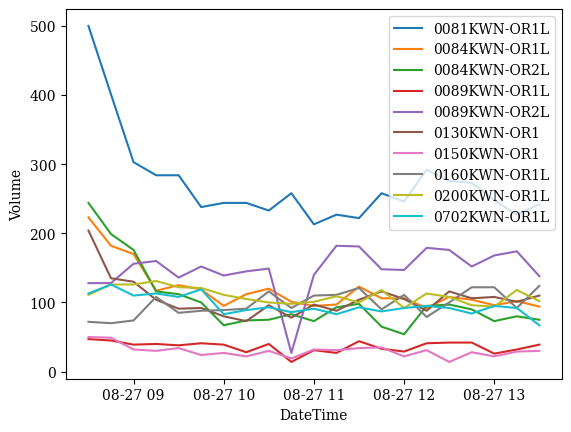

In [13]:
fig, ax = plt.subplots()
p = sns.lineplot(data=new, x='DateTime', y='Volume', hue='Row Labels', ax=ax)
ax.legend().set_title('')
plt.show()

In [14]:
res = pd.pivot_table(new, values='Volume', index='DateTime',
               columns='Row Labels').reset_index()

In [ ]:
#res.to_csv('data/OR_df.csv', index=False)

In [15]:
g = res.set_index('DateTime')

In [16]:
g['0084KWN-ORL'] = g['0084KWN-OR1L'] + g['0084KWN-OR2L']
g['0089KWN-ORL'] = g['0089KWN-OR1L'] + g['0089KWN-OR2L']
g = g[['0081KWN-OR1L', '0084KWN-ORL', '0089KWN-ORL', '0130KWN-OR1',
       '0150KWN-OR1', '0160KWN-OR1L', '0200KWN-OR1L', '0702KWN-OR1L']]
g.columns = ['H500', 'H549', 'H617', 'H547', 'H553', 'H554', 'H622', 'H558']
g

,H500,H549,H617,H547,H553,H554,H622,H558
DateTime,,,,,,,,
2018-08-27 08:30:00,500.0,467.0,175.0,204.0,50.0,72.0,111.0,113.0
2018-08-27 08:45:00,401.0,381.0,173.0,135.0,49.0,70.0,126.0,126.0
2018-08-27 09:00:00,303.0,346.0,195.0,130.0,32.0,74.0,126.0,110.0
2018-08-27 09:15:00,284.0,233.0,200.0,104.0,30.0,108.0,131.0,113.0
2018-08-27 09:30:00,284.0,237.0,174.0,91.0,34.0,85.0,122.0,108.0
2018-08-27 09:45:00,238.0,219.0,193.0,92.0,24.0,88.0,121.0,119.0
2018-08-27 10:00:00,244.0,162.0,178.0,80.0,27.0,89.0,111.0,83.0
2018-08-27 10:15:00,244.0,186.0,173.0,73.0,22.0,91.0,105.0,89.0
2018-08-27 10:30:00,233.0,195.0,189.0,96.0,30.0,116.0,100.0,93.0


In [17]:
g = g*4; g

,H500,H549,H617,H547,H553,H554,H622,H558
DateTime,,,,,,,,
2018-08-27 08:30:00,2000.0,1868.0,700.0,816.0,200.0,288.0,444.0,452.0
2018-08-27 08:45:00,1604.0,1524.0,692.0,540.0,196.0,280.0,504.0,504.0
2018-08-27 09:00:00,1212.0,1384.0,780.0,520.0,128.0,296.0,504.0,440.0
2018-08-27 09:15:00,1136.0,932.0,800.0,416.0,120.0,432.0,524.0,452.0
2018-08-27 09:30:00,1136.0,948.0,696.0,364.0,136.0,340.0,488.0,432.0
2018-08-27 09:45:00,952.0,876.0,772.0,368.0,96.0,352.0,484.0,476.0
2018-08-27 10:00:00,976.0,648.0,712.0,320.0,108.0,356.0,444.0,332.0
2018-08-27 10:15:00,976.0,744.0,692.0,292.0,88.0,364.0,420.0,356.0
2018-08-27 10:30:00,932.0,780.0,756.0,384.0,120.0,464.0,400.0,372.0


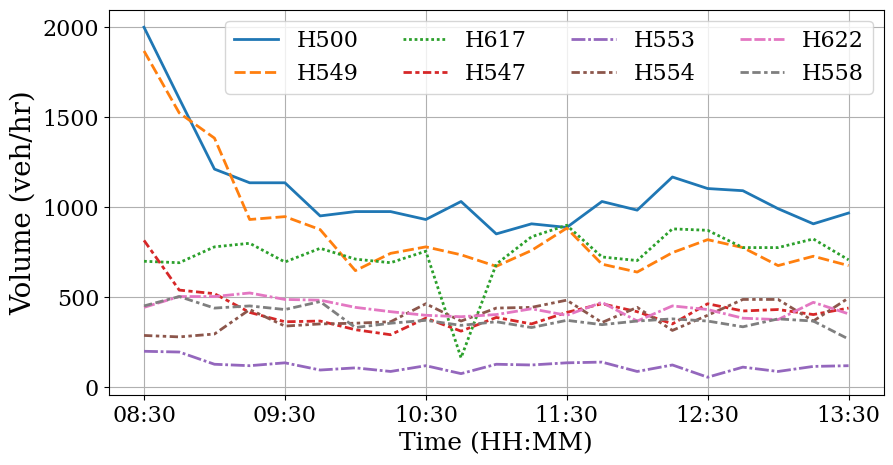

In [19]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})
fig, ax = plt.subplots(figsize=(10,5))
p = sns.lineplot(data=g, ax=ax, linewidth = 2)
ax.legend(loc='upper right', 
               ncol=round(len(g.columns)/2)).set_title('')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[30])) 
ax.set_ylabel('Volume (veh/hr)', fontsize=20)
ax.set_xlabel('Time (HH:MM)', fontsize=18)
ax.grid()
#plt.savefig('fig/Ramps_Volume', bbox_inches="tight")
plt.show()

In [ ]:
g.to_csv('data/OR_df.csv', index=False)